Making model specific cell blocks (making Data Split and Data Generator)

In [2]:
# Data Processing and Visualization
import os                  # Operating system-specific functionalities
import random              # Generates pseudo-random numbers
import glob                # Finds all the pathnames matching a specified pattern
import re                  # Regular expression operations

# Data Manipulation and Analysis
import numpy as np         # Fundamental package for scientific computing with Python
import pandas as pd        # Data manipulation and analysis library

# Image Processing and Visualization
import matplotlib.pyplot as plt   # Data visualization library
import cv2                        # OpenCV for image processing
from skimage import io            # Image I/O library from scikit-image
from PIL import Image

# Deep Learning Framework (TensorFlow/Keras)
import tensorflow as tf                     # Open-source machine learning library
from tensorflow.keras.layers import (       # Keras layers for building neural networks
    Conv2D, BatchNormalization, Activation, Conv2DTranspose, Concatenate, Input
)
from tensorflow.keras.models import Model   # Model class for defining neural network models

# Specific TensorFlow/Keras Components
from tensorflow.keras import layers, optimizers  # Different components for building and training neural networks
from tensorflow.keras.initializers import glorot_uniform  # Glorot (Xavier) weight initializer
from tensorflow.keras.utils import plot_model  # Utility for plotting model architectures
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau, 
    EarlyStopping, 
    ModelCheckpoint, 
    LearningRateScheduler
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K  # Keras backend for low-level operations

# Other Libraries
from sklearn.preprocessing import StandardScaler, normalize  # For data preprocessing
from IPython.display import display  # Display utilities for IPython environments
from keras.models import load_model  # Loading models in Keras
from keras.losses import binary_crossentropy  # Binary cross-entropy loss function


Datamap imports the path of images and store them to a variable

In [3]:
datamap = []

# Specify the path to your dataset on your Windows machine
dataset_path = "Dataset_MRI"

# Iterate over subdirectories in the specified path
for sub_dir_path in glob.glob(dataset_path + "/*"):
    # Check if the current path is a directory
    if os.path.isdir(sub_dir_path):
        # Extract the tumor type from the directory name
        dir_name = os.path.basename(sub_dir_path)

        # Iterate over files in the directory
        for filename in os.listdir(sub_dir_path):
            # Construct the full path to the image file
            image_path = os.path.join(sub_dir_path, filename)
            
            # Load the image as an array
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            
            # Check if the image is successfully loaded
            if image is not None:
                # Append a dictionary to the datamap
                datamap.append({
                    'tumor_type': dir_name,
                    'file_name': filename,
                    'image': image
                })

# Display the datamap
for entry in datamap[:10]:  # Display only the first 10 entries
    print(f"Tumor Type: {entry['tumor_type']}, File Name: {entry['file_name']}, Image Shape: {entry['image'].shape}")


Tumor Type: Gliomas, File Name: TCGA_CS_4941_19960909_11.tif, Image Shape: (256, 256, 3)
Tumor Type: Gliomas, File Name: TCGA_CS_4941_19960909_12.tif, Image Shape: (256, 256, 3)
Tumor Type: Gliomas, File Name: TCGA_CS_4941_19960909_13.tif, Image Shape: (256, 256, 3)
Tumor Type: Gliomas, File Name: TCGA_CS_4941_19960909_14.tif, Image Shape: (256, 256, 3)
Tumor Type: Gliomas, File Name: TCGA_CS_4941_19960909_15.tif, Image Shape: (256, 256, 3)
Tumor Type: Gliomas, File Name: TCGA_CS_4941_19960909_16.tif, Image Shape: (256, 256, 3)
Tumor Type: Gliomas, File Name: TCGA_CS_4942_19970222_10.tif, Image Shape: (256, 256, 3)
Tumor Type: Gliomas, File Name: TCGA_CS_4942_19970222_11.tif, Image Shape: (256, 256, 3)
Tumor Type: Gliomas, File Name: TCGA_CS_4942_19970222_12.tif, Image Shape: (256, 256, 3)
Tumor Type: Gliomas, File Name: TCGA_CS_4942_19970222_13.tif, Image Shape: (256, 256, 3)


Coverting the datamap to dataframe

In [4]:
# Assume data_map is already filled with the image data as shown in the previous steps
# Convert the data_map to a pandas DataFrame
df = pd.DataFrame(datamap)

# Display the first few rows of the DataFrame to verify its structure
print(df.head())
# print(df)

  tumor_type                     file_name  \
0    Gliomas  TCGA_CS_4941_19960909_11.tif   
1    Gliomas  TCGA_CS_4941_19960909_12.tif   
2    Gliomas  TCGA_CS_4941_19960909_13.tif   
3    Gliomas  TCGA_CS_4941_19960909_14.tif   
4    Gliomas  TCGA_CS_4941_19960909_15.tif   

                                               image  
0  [[[1, 1, 0], [1, 1, 0], [2, 2, 0], [2, 2, 0], ...  
1  [[[1, 4, 0], [2, 2, 0], [3, 2, 0], [2, 4, 0], ...  
2  [[[2, 3, 0], [3, 1, 0], [2, 2, 0], [1, 3, 0], ...  
3  [[[1, 2, 0], [1, 2, 0], [1, 4, 0], [1, 4, 0], ...  
4  [[[1, 5, 0], [2, 5, 0], [2, 4, 0], [2, 6, 0], ...  


Displaying the images before pre-processing

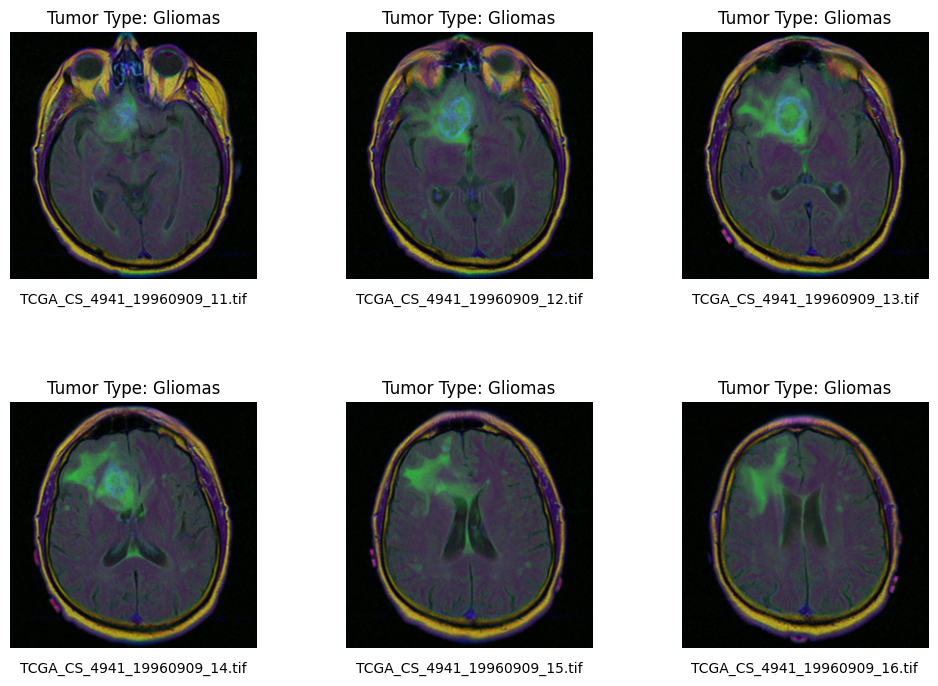

In [5]:
import math
# Define a base directory where your images are stored
base_directory = 'Dataset_MRI'

# Initialize a counter for the number of displayed images
displayed_images = 0

# Calculate the number of rows and columns for subplots based on the number of images
num_images_to_display = 6  # Change this to the desired number of images to display
num_cols = min(num_images_to_display, 3)  # Maximum 3 columns
num_rows = math.ceil(num_images_to_display / num_cols)

# Create a new figure with subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))

# Flatten the axes array if it's a single row or column
if num_images_to_display == 1:
    axes = [axes]
elif num_rows == 1:
    axes = axes[None, :]

# Iterate through the DataFrame to store the paths and display images
for index, row in df.iterrows():
    if displayed_images >= num_images_to_display:
        break  # Stop when the desired number of images have been displayed
    
    tumor_type = row['tumor_type']
    file_name = row['file_name']
    
    # Construct the full path
    full_path = os.path.join(base_directory, tumor_type, file_name)
    
    # Display the image using Matplotlib
    img = Image.open(full_path)
    
    # Determine the current row and column for the subplot
    current_row = displayed_images // num_cols
    current_col = displayed_images % num_cols
    
    # Display the image and file_name
    axes[current_row, current_col].imshow(img)
    axes[current_row, current_col].set_title(f'Tumor Type: {tumor_type}')
    axes[current_row, current_col].axis('off')
    
    # Display the file_name under the image
    axes[current_row, current_col].text(0.5, -0.1, file_name, transform=axes[current_row, current_col].transAxes, ha='center')
    
    displayed_images += 1

# Hide any empty subplots
for i in range(displayed_images, num_rows * num_cols):
    axes[i // num_cols, i % num_cols].axis('off')

# Adjust subplot spacing and display the figure
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

Pre-Processing

In [6]:
# Function to convert an image to grayscale
def convert_to_grayscale(image):
    if image is not None:
        # Convert to grayscale using cv2
        grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return grayscale_image
    return None

# Apply the function to the 'image' column to create a new 'grayscale_image' column
df['grayscale_image'] = df['image'].apply(convert_to_grayscale)

# Display the DataFrame to verify the new column
print(df.head())


  tumor_type                     file_name  \
0    Gliomas  TCGA_CS_4941_19960909_11.tif   
1    Gliomas  TCGA_CS_4941_19960909_12.tif   
2    Gliomas  TCGA_CS_4941_19960909_13.tif   
3    Gliomas  TCGA_CS_4941_19960909_14.tif   
4    Gliomas  TCGA_CS_4941_19960909_15.tif   

                                               image  \
0  [[[1, 1, 0], [1, 1, 0], [2, 2, 0], [2, 2, 0], ...   
1  [[[1, 4, 0], [2, 2, 0], [3, 2, 0], [2, 4, 0], ...   
2  [[[2, 3, 0], [3, 1, 0], [2, 2, 0], [1, 3, 0], ...   
3  [[[1, 2, 0], [1, 2, 0], [1, 4, 0], [1, 4, 0], ...   
4  [[[1, 5, 0], [2, 5, 0], [2, 4, 0], [2, 6, 0], ...   

                                     grayscale_image  
0  [[1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 3,...  
1  [[2, 1, 2, 3, 2, 1, 1, 1, 2, 2, 3, 2, 2, 2, 2,...  
2  [[2, 1, 1, 2, 1, 2, 3, 3, 4, 3, 2, 1, 1, 1, 3,...  
3  [[1, 1, 2, 2, 1, 1, 1, 2, 4, 3, 2, 2, 1, 1, 1,...  
4  [[3, 3, 3, 4, 4, 3, 2, 1, 1, 1, 1, 1, 1, 2, 2,...  


Images after Pre-Processing

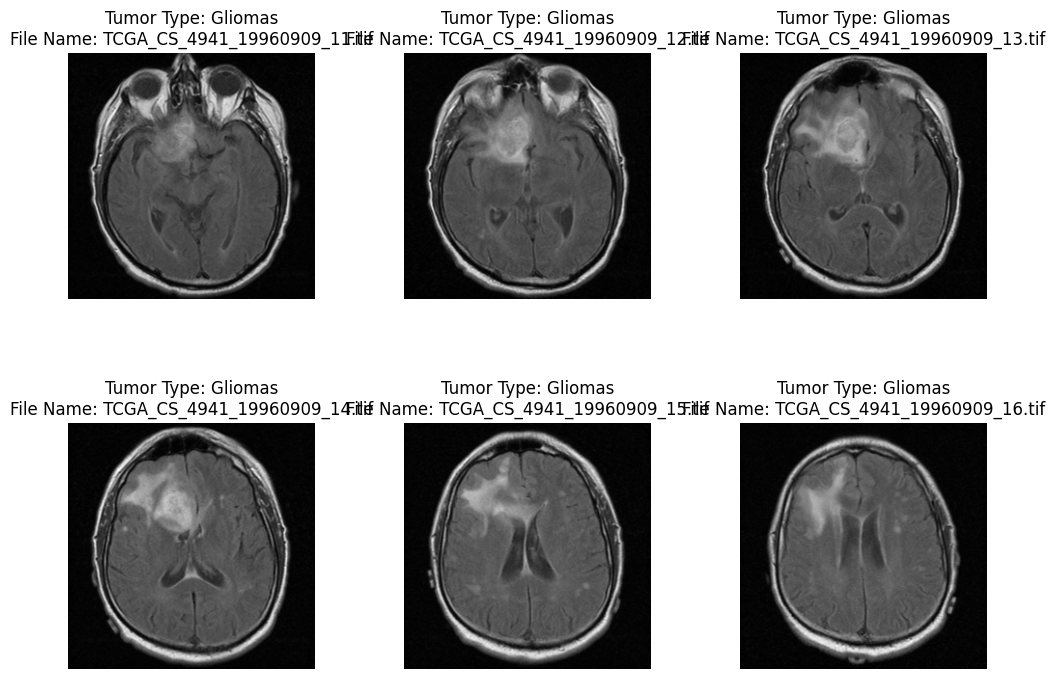

In [7]:
# Define a function to display images
def display_images(images, titles, num_cols=3):
    num_images = len(images)
    num_rows = math.ceil(num_images / num_cols)
    
    plt.figure(figsize=(12, 4 * num_rows))
    
    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(images[i], cmap='gray')  # Display grayscale images
        plt.title(titles[i])
        plt.axis('off')

# Initialize a counter for the number of displayed images
displayed_images = 0

# Calculate the number of rows and columns for subplots based on the number of images
num_images_to_display = 6  # Change this to the desired number of images to display
num_cols = min(num_images_to_display, 3)  # Maximum 3 columns
num_rows = math.ceil(num_images_to_display / num_cols)

# Create a list to store grayscale images and their titles
grayscale_images = []
image_titles = []

# Iterate through the DataFrame to store the paths and display images
for index, row in df.iterrows():
    if displayed_images >= num_images_to_display:
        break  # Stop when the desired number of images have been displayed
    
    tumor_type = row['tumor_type']
    file_name = row['file_name']
    grayscale_image = row['grayscale_image']
    
    if grayscale_image is not None:
        # Append the grayscale image and its title
        grayscale_images.append(grayscale_image)
        image_titles.append(f'Tumor Type: {tumor_type}\nFile Name: {file_name}')
    
    displayed_images += 1

# Display the grayscale images
display_images(grayscale_images, image_titles, num_cols)

# Show the plot
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()


Split data into training, testing, validation

In [8]:
from sklearn.model_selection import train_test_split

# Define your feature variable (X) and target variable (y)
X = df['grayscale_image']  # Use the 'grayscale_image' column as features
y = df['tumor_type']  # Use the 'tumor_type' column as labels

# First split: 70% training, 30% temporary test set
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Second split on the temporary test set: 50% testing, 50% validation
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Now you have X_train_temp, X_test, X_val and their corresponding y_train_temp, y_test, y_val
# You can use X_train_temp for training and X_test, X_val for testing and validation


Data Generator

In [10]:
class CustomImageDataGenerator:
    def __init__(self, dataframe, image_column, label_column, batch_size, image_size, shuffle=True, augmentation=False):
        self.dataframe = dataframe
        self.image_column = image_column
        self.label_column = label_column
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augmentation = augmentation
        self.indexes = np.arange(len(dataframe))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(len(self.dataframe) / self.batch_size))

    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = (index + 1) * self.batch_size
        batch_indices = self.indexes[start_idx:end_idx]
        
        X_batch = np.zeros((len(batch_indices), *self.image_size, 1), dtype=np.float32)
        y_batch = np.zeros((len(batch_indices),), dtype=np.int32)
        
        for i, row in enumerate(self.dataframe.iloc[batch_indices].iterrows()):
            _, data = row
            image = data[self.image_column]
            label = data[self.label_column]
            
            # Resize image to the desired size
            image = cv2.resize(image, self.image_size[::-1])
            
            # Data augmentation (if enabled)
            if self.augmentation:
                # Apply data augmentation here (e.g., rotation, flipping, etc.)
                pass
            
            # Normalize the image to [0, 1] range and store it in the batch
            X_batch[i] = image / 255.0
            y_batch[i] = label
            
        return X_batch, y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [17]:
from tensorflow.keras import layers, models

# Custom VGG16-like Encoder
def custom_vgg16_encoder(input_tensor):
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_tensor)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    s1 = x  # Save the feature map for decoder
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    s2 = x  # Save the feature map for decoder
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    s3 = x  # Save the feature map for decoder

    return s3, s2, s1

# Custom U-Net Decoder
def custom_unet_decoder(conv4, conv3, conv2, conv1):
    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv4)
    u6 = layers.concatenate([u6, conv3], axis=-1)
    u6 = layers.BatchNormalization()(u6)
    u6 = layers.Activation('relu')(u6)
    u6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    u6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    u6 = layers.Dropout(0.5)(u6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(u6)
    u7 = layers.concatenate([u7, conv2], axis=-1)
    u7 = layers.BatchNormalization()(u7)
    u7 = layers.Activation('relu')(u7)
    u7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    u7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    u7 = layers.Dropout(0.5)(u7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(u7)

    # Adjust the shape of conv1 to match the shape of u8
    conv1_adjusted = layers.Conv2D(128, (1, 1), activation='relu')(conv1)
    conv1_adjusted = layers.UpSampling2D(size=(2, 2))(conv1_adjusted)

    u8 = layers.concatenate([u8, conv1_adjusted], axis=-1)
    u8 = layers.BatchNormalization()(u8)
    u8 = layers.Activation('relu')(u8)
    u8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    u8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    u8 = layers.Dropout(0.5)(u8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(u8)
    u9 = layers.BatchNormalization()(u9)
    u9 = layers.Activation('relu')(u9)
    u9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    u9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    u9 = layers.Dropout(0.5)(u9)
    return u9

# Build Custom UNet-VGG16 Model
def build_custom_unet_vgg16_for_grayscale(input_shape, num_classes=7):  # Adjusted for 7 classes
    inputs = layers.Input(input_shape)

    """ Encoder """
    s3, s2, s1 = custom_vgg16_encoder(inputs)

    """ Decoder (U-Net) """
    u_net_decoder_output = custom_unet_decoder(s3, s2, s1, s1)

    """ Output """
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(u_net_decoder_output)

    model = models.Model(inputs, outputs, name="Custom_Brain_Tumor_Segmentation_Model")
    return model

# Create the model instance
custom_model = build_custom_unet_vgg16_for_grayscale((256, 256, 1), num_classes=7)

# Compile the model
custom_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
custom_model.summary()



Model: "Custom_Brain_Tumor_Segmentation_Model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_46 (Conv2D)          (None, 256, 256, 64)         640       ['input_3[0][0]']             
                                                                                                  
 conv2d_47 (Conv2D)          (None, 256, 256, 64)         36928     ['conv2d_46[0][0]']           
                                                                                                  
 max_pooling2d_8 (MaxPoolin  (None, 128, 128, 64)         0         ['conv2d_47[0][0]']           
 g2D)                                                        